## Excel Compiler Code
##### By Julian Thong Joon Yip

#### Set Up
1. Ensure your dataset is a file that contains the word "Data" and stored in the folder "Customer Excel Compiler" in the desktop.
2. The *Data* file should have a sheet named "Date Table" that contains the Year Month.
   <br> Example:<br>
   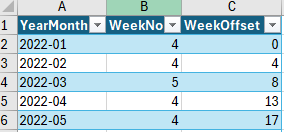
3. The dataset file itself can be split into as many sheets as long as these below columns are present in the first row. Note the data below the columns can be empty.
   <br> Example:<br>
   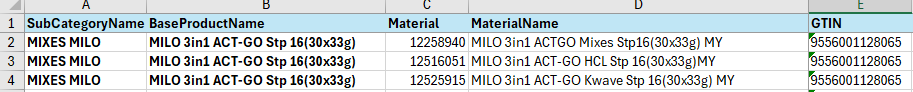
   
5. The final output is the "master_file" stored in the folder "Customer Excel Compiler".
6. _Restart the Kernal_ when trying to save Excel files or when using a new dataset
7. The output_file should be closed when running the code.

##### Code to Initialize the workspace. 
Finds the excel file that contains the text "Data" in folder "Customer Excel Compiler".

In [1]:
# Uncomment below code to install packages

#pip install openpyxl
#!pip install pandas


In [2]:
import os
import fnmatch

# Define the folder name
folder_name = 'Customer Excel Compiler'
folder_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name)

# Check if the folder exists
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"The folder {folder_path} does not exist.")

# Find all files in the folder that contain 'data' in their name (case-insensitive)
data_files = [file for file in os.listdir(folder_path) if 'data' in file.lower() and fnmatch.fnmatch(file, '*.xlsx')]

# Check if no files or more than one file is found
if not data_files:
    raise FileNotFoundError("No file containing 'data' in the name found in the folder.")
elif len(data_files) > 1:
    raise FileExistsError(f"Multiple files containing 'data' found in the folder: {', '.join(data_files)}. Please ensure only one file is present.")
else:
    # Proceed with the single found file
    file_name = data_files[0]
    file_path = os.path.join(folder_path, file_name)

    # Construct the output file name by checking if the file name contains 'data'
    if 'data' in file_name.lower():
        output_file_name = file_name.lower().replace('data', 'output_file')
    else:
        output_file_name = file_name

    output_file_path = os.path.join(folder_path, output_file_name)

print(f"File to process: {file_path}")
print(f"Output file will be saved as: {output_file_path}")


File to process: C:\Users\MYThongJJu\Desktop\Customer Excel Compiler\AEON _ALL CATEGORIES Data.xlsx
Output file will be saved as: C:\Users\MYThongJJu\Desktop\Customer Excel Compiler\aeon _all categories output_file.xlsx


##### Code to create the first sheet. 
Compiles the data from wide to long format for easier processing

In [3]:
import pandas as pd

# Load the Excel file with specifying the dtype for GTIN column to avoid scientific notation
excel_file = pd.ExcelFile(file_path)
excel_dtypes = {'GTIN': str}  # Specify dtype as string to avoid scientific notation

# Filter out the sheet named "Data Table"
sheet_names = [sheet_name for sheet_name in excel_file.sheet_names if sheet_name != 'Date Table']

# Read data from remaining sheets
df_dict = pd.read_excel(excel_file, sheet_name=sheet_names, dtype=excel_dtypes)

# Initialize an empty list to store DataFrames
data_frames = []

# Loop through each sheet in the Excel file
for sheet_name, df in df_dict.items():
    # Add a column for the sheet name
    #print(sheet_name)
    df['SheetName'] = sheet_name

    # Convert the DataFrame from wide format to long format
    df_long = df.melt(id_vars=['SubCategoryName','BaseProductName','Material', 'MaterialName', 'GTIN', 'SheetName'],
                      var_name='YearMonth',
                      value_name='Value')

    # Append the long format DataFrame to the list
    data_frames.append(df_long)

# Check if there are any DataFrames to concatenate
if data_frames:
    # Concatenate all DataFrames in the list into one master DataFrame
    master_df = pd.concat(data_frames, ignore_index=True)

    # Check if the output file already exists
    if os.path.exists(output_file_path):
        os.remove(output_file_path)  # Delete the file if it exists

    # Export the master DataFrame to a new Excel file
    master_df.to_excel(output_file_path, index=False)

    print(f"Master file created at: {output_file_path}")
else:
    print("No valid data found to compile.")


Master file created at: C:\Users\MYThongJJu\Desktop\Customer Excel Compiler\aeon _all categories output_file.xlsx


##### Code to create the summary. 
Summarizes the first sheet data in YearMonth format.

In [4]:
import pandas as pd
import os
import math

'''
# Define the folder and file names
folder_name = 'Customer Excel Compiler'
file_name = 'Customer Data.xlsx'

# Construct the file path dynamically
file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, file_name)
output_file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, 'master_file.xlsx')
'''

# Read the "Date Table" sheet from the original Excel file
date_table = pd.read_excel(file_path, sheet_name='Date Table')

# Calculate summary data
summary_data = master_df.groupby(['GTIN', 'YearMonth']).agg({'Value': 'sum'}).reset_index()
summary_data['YearMonth'] = summary_data['YearMonth'].astype(str)  # Convert YearMonth to string

# Merge summary_data with date_table based on YearMonth
summary_data = summary_data.merge(date_table[['YearMonth', 'WeekNo']], on='YearMonth', how='left')

# Calculate forecast_qty
summary_data['forecast_qty'] = summary_data['Value'] / summary_data['WeekNo']
summary_data['forecast_qty'] = summary_data['forecast_qty'].apply(lambda x: math.ceil(x))  # Round up to the nearest integer

# Rename columns
summary_data.rename(columns={'GTIN': 'product_code', 'Value': 'total_value'}, inplace=True)

# Create a new Excel writer object
with pd.ExcelWriter(output_file_path, engine='openpyxl', mode='a') as writer:
    if 'summary' in pd.ExcelFile(output_file_path).sheet_names:
        # Remove existing 'summary' sheet
        writer.book.remove(writer.book['summary'])

    # Write the summary data to a new sheet
    summary_data.to_excel(writer, sheet_name='summary', index=False)

# Check if the summary sheet was successfully added or replaced
if 'summary' in pd.ExcelFile(output_file_path).sheet_names:
    print(f"Summary sheet at: {output_file_path}")
else:
    print("Failed to add/replace the summary sheet.")


Summary sheet at: C:\Users\MYThongJJu\Desktop\Customer Excel Compiler\aeon _all categories output_file.xlsx


#### Code to create "Summary Year-Week" sheet in master_file
Final output of the dataset.
- product_code : Taken from GTIN in summary sheet
- year_month_week: Added number of weeks for each Year_Month based on the "Customer Data" Date Table Sheet
- year_week: Combination of the Year and Week in format (yyyymm)
- forecast_qty: Taken from summary sheet and duplicated for each product_code in a given year_month

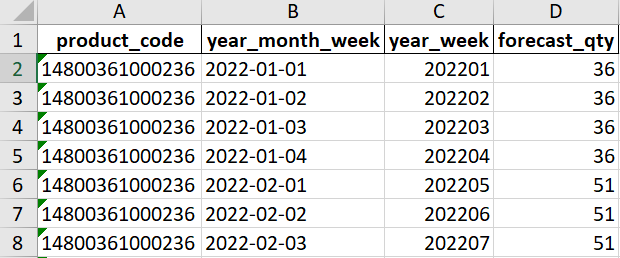

In [5]:
import pandas as pd
'''
# Define the folder and file names
folder_name = 'Customer Excel Compiler'
file_name = 'Customer Data.xlsx'

# Construct the file path dynamically
file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, file_name)
output_file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, 'master_file.xlsx')

# Specify the paths to your Excel files
file_path_master = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, 'master_file.xlsx')
'''
# Read the 'summary' sheet from the Excel file
summary_df = pd.read_excel(output_file_path, sheet_name='summary')

# Read the 'Date Table' sheet from the Customer file
date_table_df = pd.read_excel(file_path, sheet_name='Date Table')

# Merge the summary_df with date_table_df on 'YearMonth' to add 'WeekOffset' column
expanded_summary_df = summary_df.merge(date_table_df[['YearMonth', 'WeekOffset']], on='YearMonth', how='left')

# Create an empty list to store the expanded summary data
expanded_summary_data = []

# Iterate through each row in the summary DataFrame
for _, row in expanded_summary_df.iterrows():
    # Format product_code to match GTIN format (leading zeros)
    #product_code = str(row['product_code']).zfill(14)
    product_code = str(row['product_code'])
    year_month = row['YearMonth']
    week_no = row['WeekNo']
    forecast_qty = row['forecast_qty']
    week_offset = row['WeekOffset']
    
    # Create new rows for each week based on the 'WeekNo' value
    for week in range(1, week_no + 1):
        year_month_week = f"{year_month}-{str(week).zfill(2)}"  # Combine YearMonth and week number
        # Calculate year_week by adding WeekOffset to the week number
        year_week = int(f"{year_month.split('-')[0]}{week + week_offset:02}")  # Year + week
        expanded_summary_data.append({'product_code': product_code, 'year_month_week': year_month_week, 'year_week': year_week, 'forecast_qty': forecast_qty})

# Create a new DataFrame from the expanded summary data
expanded_summary_df = pd.DataFrame(expanded_summary_data)

# Create a new Excel writer object
with pd.ExcelWriter(output_file_path, engine='openpyxl', mode='a') as writer:
    # Replace the existing 'Summary Year-Week' sheet with the new one
    if 'Summary Year-Week' in pd.ExcelFile(output_file_path).sheet_names:
        writer.book.remove(writer.book['Summary Year-Week'])
    
    # Write the expanded summary data to a new sheet
    expanded_summary_df.to_excel(writer, sheet_name='Summary Year-Week', index=False)

print("Summary Year-Week sheet created successfully.")


Summary Year-Week sheet created successfully.
